## Michine Learning Project

### Lei Liu(ll34246)

#### Background Introduction/Objective

Interpretation of seismic data can help us clarify oil/brine/gas zones. For example, clay content can be determined based on the relationship between seismic velocity data and acoustic impedance data. Although this relationship provides a reference for understanding the formation properties, the quality of this interpretation depends on in-situ formation properties and data quality. Machine learning methods show promises in helping to classify several clusters among original dataset and improve the understanding of seismic responses. In this project, we’ll apply and compare several different clustering methods on seismic data and help clarify clay zones based on Vp/Vs vs AI relationship. 

The objective is to classify appropriate number of groups in Vp/Vs vs Ip space and compare these groups with clay zones. We will apply different clustering methods (k-means, DBSCAN and GMM) to realize this objective.

#### Executive Summary

* In this project, we applied several clustering methods on seismic velocity and impedance dataset 
* K-means clustering, DBSCAN, and GaussianMixture models are used to classify appropriate number of groups in the feature space to see if this classification helps predict clay zones
* we discussed the clustering results and compared them with the original clay zones classification
* K-means clustering methods does not perform well during classification, DBSCAN results only classify several clay zones as we expected, GaussianMisture shows much better performance compared with other two methods but still several points fall into wrong groups.

#### Install packages

we need to import some basic packages first

In [2]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python  

import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
import copy                               # for deep copies
from sklearn.neighbors import NearestNeighbors # nearest neighbours function to calculate eps hyperparameter
from sklearn.preprocessing import MinMaxScaler # min/max normalization

from sklearn.cluster import KMeans        # k-means clustering
from sklearn.cluster import DBSCAN        # DBSCAN clustering
from sklearn.mixture import GaussianMixture    # Guassian Mixture Model
cmap = plt.cm.inferno

#### set the working directory

In [3]:
os.chdir(r"C:\Users\leili\Documents\PGE383")

#### load dataset 

In [10]:
col = ['Ip','Vp/Vs','Vclay']
#units = ['kg/m2*10^3','%']
df = pd.read_csv('Projectdata.csv')    # load our data table
xlim = [4,11]; ylim = [1.5,2.5]; xlabel = 'Ip'; ylabel = 'Vp/Vs'

df = df[[col[0],col[1],col[2]]]
df.head()
df = df.sample(frac=0.1, random_state = 73073); # extract 10% random to reduce the number of data

#### summary statistic of our dataset

In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Ip,594.0,5.760656,0.800647,4.354457,5.076424,5.845526,6.287376,10.550769
Vp/Vs,594.0,2.129463,0.131467,1.675086,2.035927,2.140069,2.210531,2.399778
Vclay,594.0,0.551715,0.252270,0.000000,0.341850,0.699400,0.750000,0.750000


* The two features(Ip and Vp/Vs) do not show a significant difference in magnitude.
* Regarding some of the clustering methods are based on distance calculation, we still apply normalization of these features to get a comparison of clustering results.

In [13]:
transform = MinMaxScaler(); 
features = [col[0],col[1]]

df['n' + col[0]] = transform.fit_transform(df.loc[:,features].values)[:,0] # standardize the data features to mean = 0, var = 1.0
df['n' + col[1]] = transform.fit_transform(df.loc[:,features].values)[:,1] # standardize the data features to mean = 0, var = 1.0
df.head()

,Ip,Vp/Vs,Vclay,nIp,nVp/Vs
5404,5.967928,2.171860,0.7500,0.260392,0.685496
2339,5.533951,2.221671,0.7500,0.190354,0.754230
3122,6.446809,2.027330,0.4985,0.337677,0.486060
4352,5.718328,2.020652,0.2650,0.220110,0.476845
4890,6.928586,1.906355,0.1815,0.415429,0.319127


now check the statistic again

In [17]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Ip,594.0,5.760656,0.800647,4.354457,5.076424,5.845526,6.287376,10.550769
Vp/Vs,594.0,2.129463,0.131467,1.675086,2.035927,2.140069,2.210531,2.399778
Vclay,594.0,0.551715,0.252270,0.000000,0.341850,0.699400,0.750000,0.750000
nIp,594.0,0.226941,0.129214,0.000000,0.116516,0.240638,0.311947,1.000000
nVp/Vs,594.0,0.626993,0.181410,0.000000,0.497922,0.641628,0.738858,1.000000


* we set a seed number to make sure we will get the same results every time we run this workflow.

* we create a dictionary for assigning differnet colors of each cluster.

* we initially set K=3 (will be explained next)

In [18]:
np.random.seed(210)
K = 3                                     # number of prototypes
colmap = {1: 'r', 2: 'g', 3: 'b', 4: 'm', 5: 'c', 6: 'k', 7: 'w'}

#### Visualization of training data

Let's first look at our training features (Vp/Vs and Ip) as well as predictore festures(Vclay-clay content). 

* The first two figures show only relationship of Vp/Vs and Ip (no predictor feature attached)

* From the last figure, we can classify these points into three groups (K=3)  
1.Vclay=0   2. 0<Vclay<0.66   3. Vclay>=0.66

<ipython-input-31-25537cbb89de>:3: MatplotlibDeprecationWarning: The 'verts' parameter of scatter() is deprecated since Matplotlib 3.2 and will be removed two minor releases later.  If any parameter follows 'verts', they should be pass as keyword, not positionally.
  plt.scatter(df[col[0]], df[col[1]], alpha = 0.3,  linewidths=1.0, verts=None, edgecolors="black")
<ipython-input-31-25537cbb89de>:9: MatplotlibDeprecationWarning: The 'verts' parameter of scatter() is deprecated since Matplotlib 3.2 and will be removed two minor releases later.  If any parameter follows 'verts', they should be pass as keyword, not positionally.
  plt.scatter(df['n' + col[0]], df['n' + col[1]], alpha = 0.3, linewidths=1.0, verts=None, edgecolors="black")


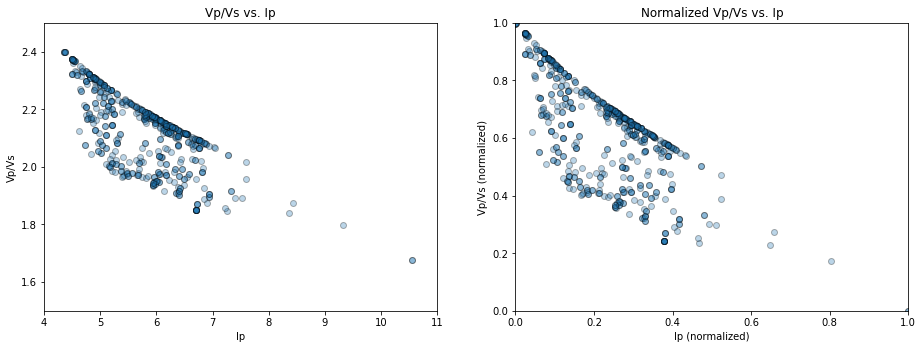

In [31]:
# scatter plot our training data  
plt.subplot(121)
plt.scatter(df[col[0]], df[col[1]], alpha = 0.3,  linewidths=1.0, verts=None, edgecolors="black")
plt.title(col[1] + ' vs. ' + col[0]); plt.xlabel(xlabel); plt.ylabel(ylabel)
plt.xlim(xlim)
plt.ylim(ylim)

plt.subplot(122)
plt.scatter(df['n' + col[0]], df['n' + col[1]], alpha = 0.3, linewidths=1.0, verts=None, edgecolors="black")
plt.title('Normalized ' + col[1] + ' vs. ' + col[0])
plt.xlabel(xlabel + ' (normalized)'); 
plt.ylabel(ylabel + ' (normalized)')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

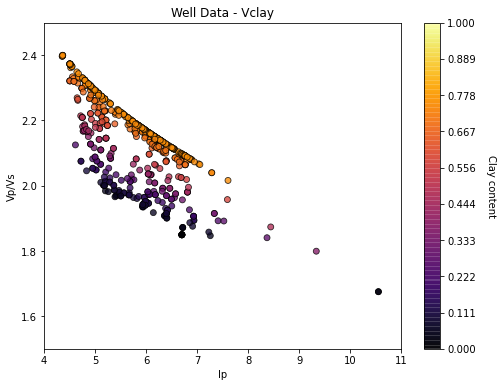

In [19]:
GSLIB.locmap(df,'Ip','Vp/Vs','Vclay',4,11,1.5,2.5,0,1,'Well Data - Vclay','Ip','Vp/Vs','Clay content',cmap,'locmap_clay')

#### K-Means Clustering

Firstly we apply k-means clustering methods

* the coding comes from Michael Pyrcz, an associat eprofessor from Univeristy of Texas at Austin
[GItHub](https://github.com/GeostatsGuy)

From the clusteirng results, we observed that data points are divided into three groups as we expected.
However, this clusteirng result is not well compared with the original clay zones. Some datapoints were classified as wrong clay zones.  Regarding the theory of this methods, these issues can be expected.

<ipython-input-44-22d6e0edda61>:16: MatplotlibDeprecationWarning: The 'verts' parameter of scatter() is deprecated since Matplotlib 3.2 and will be removed two minor releases later.  If any parameter follows 'verts', they should be pass as keyword, not positionally.
  plt.scatter(df['n' + col[0]], df['n' + col[1]], c=df['kMeans'], alpha = 0.4, linewidths=1.0, verts=None, edgecolors="black", cmap = cmap)


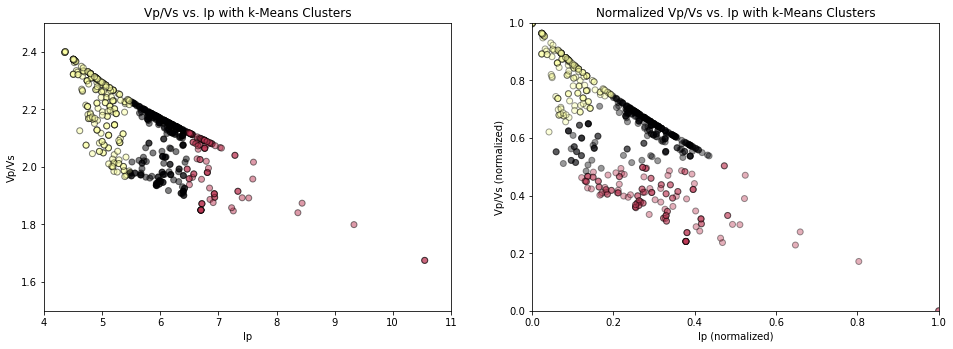

In [44]:
kmeans_orig = KMeans(n_clusters=3, random_state=0).fit(df[[col[0],col[1]]].values)
df['kMeans_orig'] = kmeans_orig.labels_ + 1

kmeans = KMeans(n_clusters=3, random_state=0).fit(df[['n'+col[0],'n'+col[1]]].values)
df['kMeans'] = kmeans.labels_ + 1

cmap = plt.cm.inferno

plt.subplot(131)                          # plot the assigned training data and K prototypes
plt.scatter(df[col[0]], df[col[1]], c=df['kMeans_orig'],alpha=0.5, edgecolor='k', cmap = cmap)
plt.title('Vp/Vs vs. Ip with k-Means Clusters'); plt.xlabel(xlabel); plt.ylabel(ylabel)
plt.xlim(xlim)
plt.ylim(ylim)

plt.subplot(132)                          # plot normalized training data and K prototypes
plt.scatter(df['n' + col[0]], df['n' + col[1]], c=df['kMeans'], alpha = 0.4, linewidths=1.0, verts=None, edgecolors="black", cmap = cmap)
plt.title('Normalized ' + col[1] + ' vs. ' + col[0] + ' with k-Means Clusters'); plt.xlabel(xlabel + ' (normalized)'); plt.ylabel(ylabel + ' (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.0, wspace=0.2, hspace=0.2)


#### DBSCAN Clustering

In DBSCAN methods, there is no need to set the number of clusters before clustering. But we need to figure out two parameters.
* eps: radius of the local neighborhood
* min_samples: minimum number of points to assign a core point

<ipython-input-45-457930b9db5e>:16: MatplotlibDeprecationWarning: The 'verts' parameter of scatter() is deprecated since Matplotlib 3.2 and will be removed two minor releases later.  If any parameter follows 'verts', they should be pass as keyword, not positionally.
  plt.scatter(df_in['n'+col[0]], df_in['n'+col[1]], c=df_in['DBSCAN'], alpha = 0.4, linewidths=1.0, verts=None, edgecolors="black", cmap = cmap)


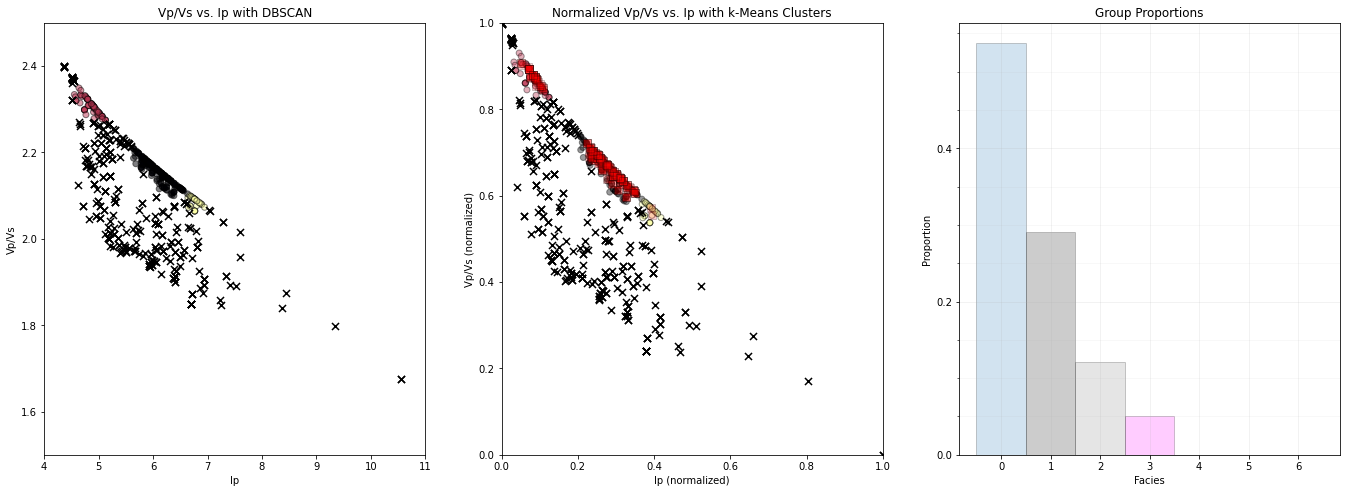

In [45]:
dbscan = DBSCAN(eps=0.025, min_samples=21).fit(df[['n'+col[0],'n'+col[1]]].values)
df['DBSCAN'] = dbscan.labels_ + 1

cmap = plt.cm.inferno

plt.subplot(131)                          # plot the assigned training data and K prototypes
df_in = df.loc[(df['DBSCAN'] != 0)]
plt.scatter(df_in[col[0]], df_in[col[1]], c=df_in['DBSCAN'], alpha=0.5, edgecolor='k', cmap = cmap)
df_outlier = df.loc[(df['DBSCAN'] == 0)]
plt.scatter(df_outlier[col[0]],df_outlier[col[1]],c='black',s = 50,marker = 'x',edgecolor='k',cmap = cmap)
plt.title(col[1] + ' vs. ' + col[0] + ' with DBSCAN'); plt.xlabel(xlabel); plt.ylabel(ylabel)
plt.xlim(xlim)
plt.ylim(ylim)

plt.subplot(132)                          # plot the training data and K prototypes
plt.scatter(df_in['n'+col[0]], df_in['n'+col[1]], c=df_in['DBSCAN'], alpha = 0.4, linewidths=1.0, verts=None, edgecolors="black", cmap = cmap)
plt.scatter(df_outlier['n'+col[0]],df_outlier['n'+col[1]],c='black',s = 50,marker = 'x',edgecolor='k',cmap = cmap)
# option to visualize the identified core samples
plt.scatter(dbscan.components_[:,0],dbscan.components_[:,1],c='red',s=50,marker = 's',edgecolor='k',cmap = cmap,alpha = 0.2)
plt.title('Normalized ' + col[1] + ' vs. ' + col[0] + ' with k-Means Clusters'); plt.xlabel(xlabel + ' (normalized)'); plt.ylabel(ylabel + ' (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2)

plt.subplot(133)
N, bins, patches  = plt.hist(df['DBSCAN'],alpha=0.2,edgecolor="black",bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5],range=[0.5,2.5],density = True)
patches[1].set_facecolor('black'); patches[3].set_facecolor('magenta'); patches[4].set_facecolor('red')
patches[5].set_facecolor('yellow'); patches[6].set_facecolor('white'); patches[2].set_facecolor('gray');
plt.title('Group Proportions')
plt.xlabel('Facies')
plt.ylabel("Proportion")
ax = plt.gca()
ax.set_xticks(np.arange(0.0, 6.1, 1))
ax.set_yticks(np.arange(0, 0.6, 0.2))
ax.set_yticks(np.arange(0, 0.6, 0.05), minor=True)

#plt.grid(which = 'both',color = 'black',alpha = 0.01)
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.2)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.50, wspace=0.2, hspace=0.2)

Let's explore the sensitivity in the parameters by looking at the results over a 3*3 combinational of hyperparameters.

     eps_mat = [0.023,0.025,0.027]
     min_sample_mat = [20,21,22]

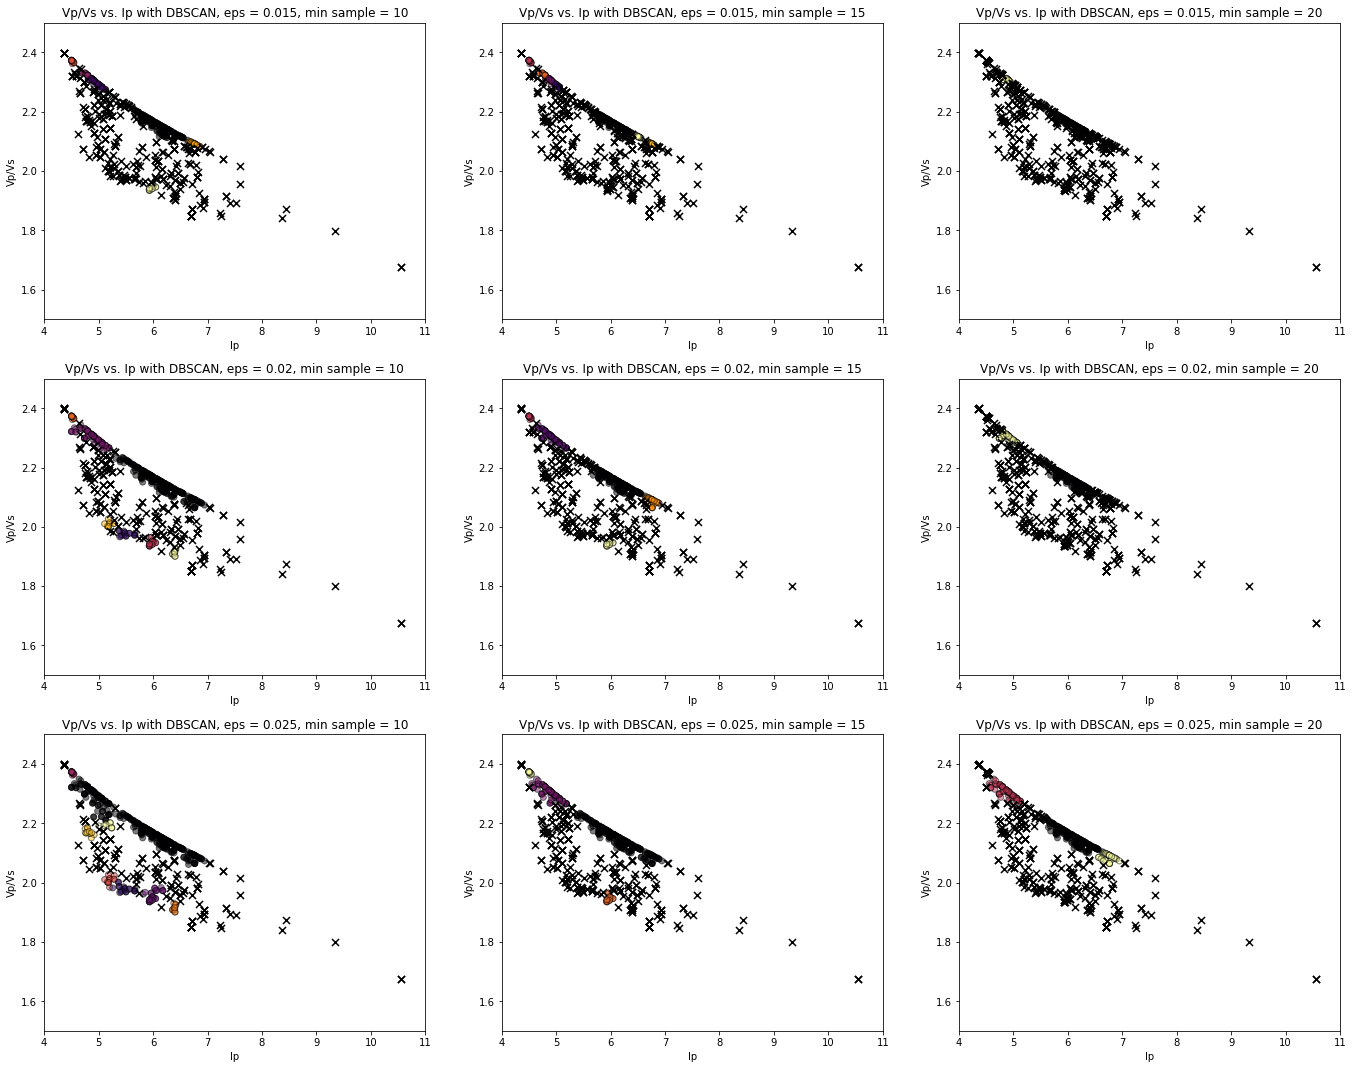

In [46]:
eps_mat = [0.015,0.02,0.025] 
min_sample_mat = [10, 15, 20]

index = 1
for eps in eps_mat:
    for min_sample in min_sample_mat:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample).fit(df[['n'+col[0],'n'+col[1]]].values)
        df['DBSCAN'] = dbscan.labels_ + 1
        
        plt.subplot(3,3,index)                          # plot the assigned training data and K prototypes
        df_in = df.loc[(df['DBSCAN'] != 0)]
        plt.scatter(df_in[col[0]], df_in[col[1]], c=df_in['DBSCAN'], alpha=0.5, edgecolor='k', cmap = cmap)
        df_outlier = df.loc[(df['DBSCAN'] == 0)]
        plt.scatter(df_outlier[col[0]],df_outlier[col[1]],c='black',s = 50,marker = 'x',edgecolor='k',cmap = cmap)
        plt.title(col[1] + ' vs. ' + col[0] + ' with DBSCAN, eps = ' + str(eps) + ', min sample = ' + str(min_sample)); plt.xlabel(xlabel); plt.ylabel(ylabel)
        plt.xlim(xlim)
        plt.ylim(ylim)
        index = index + 1
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.50, wspace=0.2, hspace=0.2)

Now let's calculate the DBSCAN hyperparameters.

 - min samples: we will assume 10
 - eps: we use nearest neighbor function

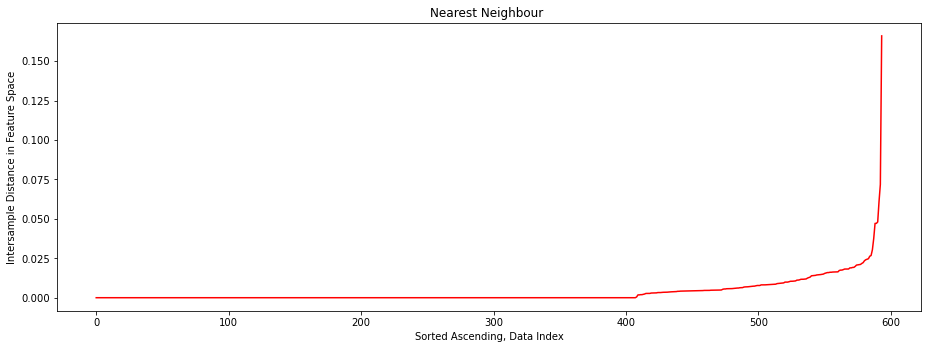

In [93]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df[['n' + col[0],'n' + col[1]]].values)
distances, indices = nbrs.kneighbors(df[['n' + col[0],'n' + col[1]]].values)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances, c = 'red'); plt.xlabel('Sorted Ascending, Data Index'); plt.ylabel('Intersample Distance in Feature Space')
plt.title('Nearest Neighbour ')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.00, wspace=0.2, hspace=0.2)

The nearest neighbor distance with the maximum positive curvature is about 0.023. Then we apply this value and look at the clustering results again.

Although the results show some satisfying clay zones classification (high clay and medium clay content zones), the low clay content zone groups are not classified well.

<ipython-input-48-4263cc722849>:16: MatplotlibDeprecationWarning: The 'verts' parameter of scatter() is deprecated since Matplotlib 3.2 and will be removed two minor releases later.  If any parameter follows 'verts', they should be pass as keyword, not positionally.
  plt.scatter(df_in['n' + col[0]], df_in['n' + col[1]], c=df_in['DBSCAN'], alpha = 0.4, linewidths=1.0, verts=None, edgecolors="black", cmap = cmap)


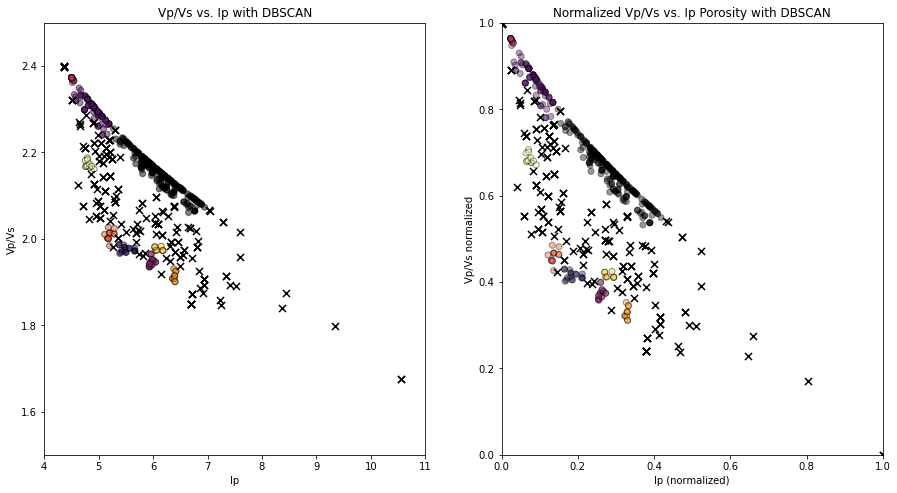

In [48]:
dbscan = DBSCAN(eps=0.023, min_samples=11).fit(df[['n' + col[0],'n' + col[1]]].values)
df['DBSCAN'] = dbscan.labels_ + 1

cmap = plt.cm.inferno

plt.subplot(131)                          # plot the assigned training data and K prototypes
df_in = df.loc[(df['DBSCAN'] != 0)]
plt.scatter(df_in[col[0]], df_in[col[1]], c=df_in['DBSCAN'], alpha=0.5, edgecolor='k', cmap = cmap)
df_outlier = df.loc[(df['DBSCAN'] == 0)]
plt.scatter(df_outlier[col[0]],df_outlier[col[1]],c='black',s = 50,marker = 'x',edgecolor='k',cmap = cmap)
plt.title(col[1] + ' vs. ' + col[0] + ' with DBSCAN'); plt.xlabel(xlabel); plt.ylabel(ylabel)
plt.xlim(xlim)
plt.ylim(ylim)

plt.subplot(132)                          # plot the training data and K prototypes
plt.scatter(df_in['n' + col[0]], df_in['n' + col[1]], c=df_in['DBSCAN'], alpha = 0.4, linewidths=1.0, verts=None, edgecolors="black", cmap = cmap)
plt.scatter(df_outlier['n' + col[0]],df_outlier['n' +col[1]],c='black',s = 50,marker = 'x',edgecolor='k',cmap = cmap)
# option to visualize the identified core samples
#plt.scatter(dbscan.components_[:,0],dbscan.components_[:,1],c='red',s=50,marker = 's',edgecolor='k',cmap = cmap,alpha = 0.2)
plt.title('Normalized ' + col[1] + ' vs. ' + col[0] + ' Porosity with DBSCAN'); plt.xlabel(xlabel + ' (normalized)'); plt.ylabel(ylabel + ' normalized')
plt.xlim(0, 1)
plt.ylim(0, 1)

#plt.grid(which = 'both',color = 'black',alpha = 0.01)
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.2)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.50, wspace=0.2, hspace=0.2)

### GaussianMixture

Coding from Ron Weiss <ronweiss@gmail.com>, Gael Varoquaux

A gaussian mixture model is a probabilistic model that assumes all data points are generated from a mixture of a finite number of Guassian distributions. Figur below is cited from scikit.learn and it compares different clustering algorithms on dataset. Considring our dataset is close to the fourth line models, we attempted the GaussianMixture model which shows the best clustering results as we expected.

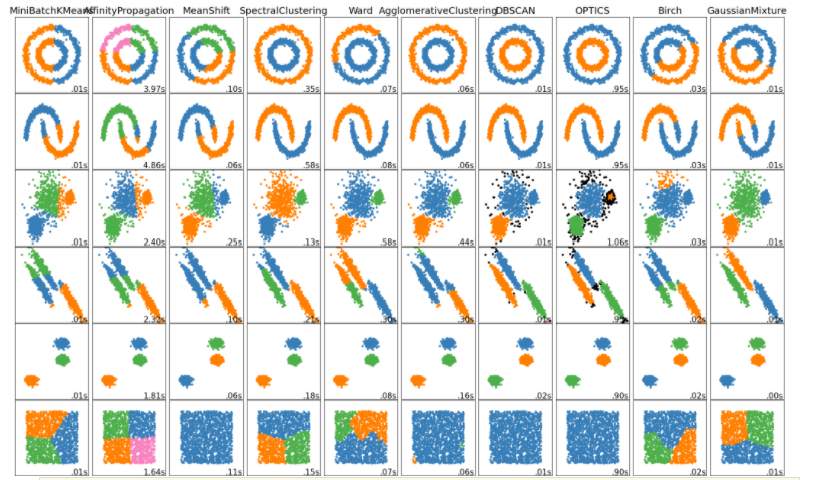

In [55]:
'''
plt.figure(figsize=(7,7))
plt.scatter(df["Ip"],df["Vp/Vs"])
plt.xlabel('Ip')
plt.ylabel('Vp/Vs')
plt.title('Vp/Vs  vs.  Ip')
plt.show()
'''

'\nplt.figure(figsize=(7,7))\nplt.scatter(df["Ip"],df["Vp/Vs"])\nplt.xlabel(\'Ip\')\nplt.ylabel(\'Vp/Vs\')\nplt.title(\'Vp/Vs  vs.  Ip\')\nplt.show()\n'

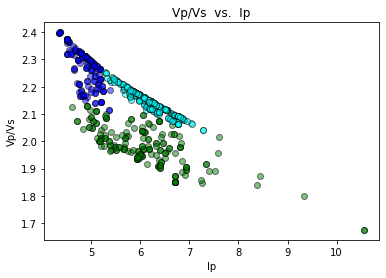

In [56]:
import pandas as pd
data = df.iloc[:,:2]

# training gaussian mixture model 

n_components = 3
  
gmm = GaussianMixture(n_components)
gmm.fit(data)

#predictions from gmm
labels = gmm.predict(data)
frame = pd.DataFrame(data)
frame['cluster'] = labels
frame.columns = ['Ip', 'Vp/Vs', 'cluster']
color=['blue','green','cyan','black']

for k in range(0,3):
    data = frame[frame["cluster"]==k]
    plt.scatter(data["Ip"],data["Vp/Vs"],c=color[k],alpha=0.5, edgecolor='k',)
    
plt.xlabel('Ip')
plt.ylabel('Vp/Vs')
plt.title('Vp/Vs  vs.  Ip')
plt.show()
#plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2)

From the GaussianMixture results, it can be seen that high clay content zone (blue points) is classified well, but there are still some points fall into another group.

We set the clusters=3 before clustering and did not apply the best number of clusters.